## 1. Import Libraries

In [7]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import eda_helper_functions

from sklearn.ensemble import IsolationForest

## 2. Read the Training Data

In [8]:
file_path = r"D:\Flights-sagemaker-project\data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-03-01,Delhi,Cochin,00:20:00,15:30:00,910,1,No Info,23170
1,Air Asia,2019-03-24,Banglore,New Delhi,05:50:00,08:40:00,170,0,No Info,3383
2,Jet Airways,2019-05-27,Delhi,Cochin,10:00:00,12:35:00,1595,1,In-flight meal not included,12898
3,Indigo,2019-03-06,Chennai,Kolkata,13:20:00,15:35:00,135,0,No Info,7295
4,Jet Airways,2019-05-09,Banglore,Delhi,18:55:00,22:00:00,185,0,In-flight meal not included,3702
...,...,...,...,...,...,...,...,...,...,...
7317,Air India,2019-03-03,Delhi,Cochin,09:45:00,09:25:00,1420,1,No Info,24017
7318,Jet Airways,2019-03-27,Delhi,Cochin,19:15:00,19:45:00,1470,1,No Info,12032
7319,Jet Airways,2019-04-01,Kolkata,Banglore,21:10:00,08:15:00,665,1,In-flight meal not included,8849
7320,Indigo,2019-06-12,Delhi,Cochin,11:25:00,01:30:00,845,1,No Info,5883


### 2.1 Fixing Data Types

In [9]:
train.dtypes

airline            object
date_of_journey    object
source             object
destination        object
dep_time           object
arrival_time       object
duration            int64
total_stops         int64
additional_info    object
price               int64
dtype: object

In [10]:
train = train.assign(**{
	col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
	for col in ["date_of_journey", "dep_time", "arrival_time"]
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops                 int64
additional_info            object
price                       int64
dtype: object

In [11]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-03-01,Delhi,Cochin,2024-05-14 00:20:00,2024-05-14 15:30:00,910,1,No Info,23170
1,Air Asia,2019-03-24,Banglore,New Delhi,2024-05-14 05:50:00,2024-05-14 08:40:00,170,0,No Info,3383
2,Jet Airways,2019-05-27,Delhi,Cochin,2024-05-14 10:00:00,2024-05-14 12:35:00,1595,1,In-flight meal not included,12898
3,Indigo,2019-03-06,Chennai,Kolkata,2024-05-14 13:20:00,2024-05-14 15:35:00,135,0,No Info,7295
4,Jet Airways,2019-05-09,Banglore,Delhi,2024-05-14 18:55:00,2024-05-14 22:00:00,185,0,In-flight meal not included,3702
...,...,...,...,...,...,...,...,...,...,...
7317,Air India,2019-03-03,Delhi,Cochin,2024-05-14 09:45:00,2024-05-14 09:25:00,1420,1,No Info,24017
7318,Jet Airways,2019-03-27,Delhi,Cochin,2024-05-14 19:15:00,2024-05-14 19:45:00,1470,1,No Info,12032
7319,Jet Airways,2019-04-01,Kolkata,Banglore,2024-05-14 21:10:00,2024-05-14 08:15:00,665,1,In-flight meal not included,8849
7320,Indigo,2019-06-12,Delhi,Cochin,2024-05-14 11:25:00,2024-05-14 01:30:00,845,1,No Info,5883


## 3. High-level Summary of Data

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7322 entries, 0 to 7321
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          7322 non-null   object        
 1   date_of_journey  7322 non-null   datetime64[ns]
 2   source           7322 non-null   object        
 3   destination      7322 non-null   object        
 4   dep_time         7322 non-null   datetime64[ns]
 5   arrival_time     7322 non-null   datetime64[ns]
 6   duration         7322 non-null   int64         
 7   total_stops      7322 non-null   int64         
 8   additional_info  7322 non-null   object        
 9   price            7322 non-null   int64         
dtypes: datetime64[ns](3), int64(3), object(4)
memory usage: 572.2+ KB


In [13]:
train.describe(include="number")

,duration,total_stops,price
count,7322.000000,7322.000000,7322.000000
mean,625.392652,0.795275,9031.446190
std,498.713890,0.656169,4705.053515
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,500.000000,1.000000,8266.000000
75%,903.750000,1.000000,12321.000000
max,2860.000000,4.000000,79512.000000


In [14]:
(
	train
	.assign(total_stops=train["total_stops"].astype(object))
	.describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,7322,7322,7322,7322,7322
unique,9,5,6,5,8
top,Jet Airways,Delhi,Cochin,1,No Info
freq,2592,3005,3005,3949,5715


## 4. High-level analysis of Missing Values

In [15]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


## 5. High-level analysis of Outliers

In [17]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [18]:
(
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
		.select_dtypes(include="number")
	))
	.query("outlier == -1")
	# .duration
	# .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
2,Jet Airways,2019-05-27,Delhi,Cochin,2024-05-14 10:00:00,2024-05-14 12:35:00,1595,1,In-flight meal not included,12898,-1
3,Indigo,2019-03-06,Chennai,Kolkata,2024-05-14 13:20:00,2024-05-14 15:35:00,135,0,No Info,7295,-1
4,Jet Airways,2019-05-09,Banglore,Delhi,2024-05-14 18:55:00,2024-05-14 22:00:00,185,0,In-flight meal not included,3702,-1
5,Air India,2019-05-06,Kolkata,Banglore,2024-05-14 09:10:00,2024-05-14 13:15:00,245,1,No Info,8996,-1
9,Vistara,2019-05-21,Kolkata,Banglore,2024-05-14 07:10:00,2024-05-14 10:45:00,1655,1,No Info,9187,-1
...,...,...,...,...,...,...,...,...,...,...,...
7310,Indigo,2019-03-06,Mumbai,Hyderabad,2024-05-14 02:30:00,2024-05-14 04:00:00,90,0,No Info,3175,-1
7311,Air India,2019-03-09,Banglore,New Delhi,2024-05-14 06:50:00,2024-05-14 23:10:00,980,1,No Info,5626,-1
7315,Indigo,2019-03-09,Mumbai,Hyderabad,2024-05-14 09:10:00,2024-05-14 10:35:00,85,0,No Info,7417,-1
7317,Air India,2019-03-03,Delhi,Cochin,2024-05-14 09:45:00,2024-05-14 09:25:00,1420,1,No Info,24017,-1


## 6. Pair Plots

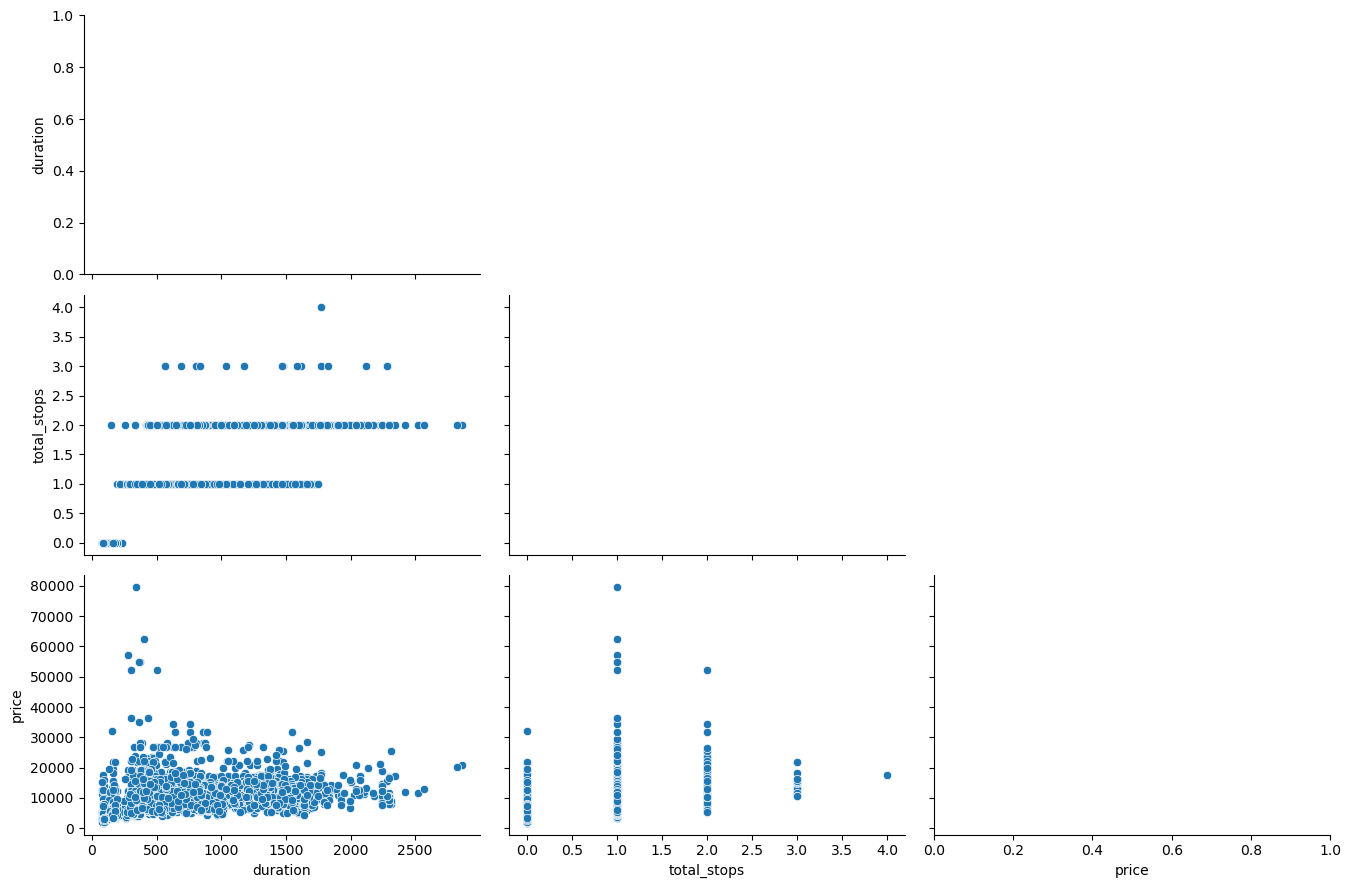

In [19]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

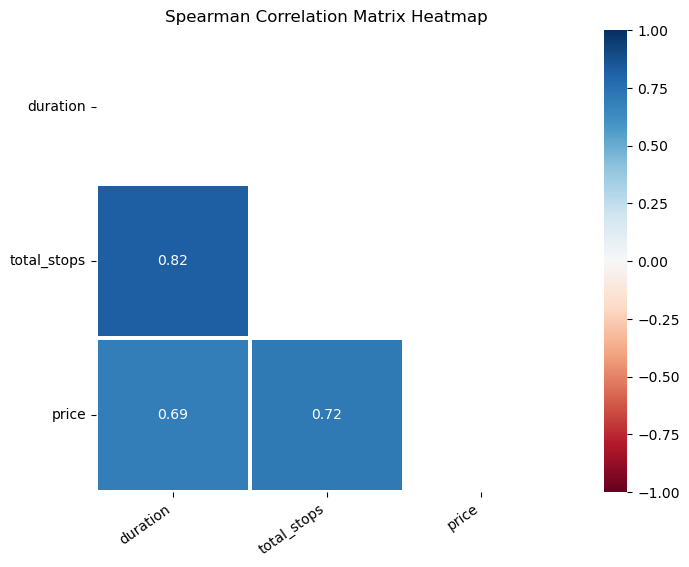

In [20]:
eda_helper_functions.correlation_heatmap(train)

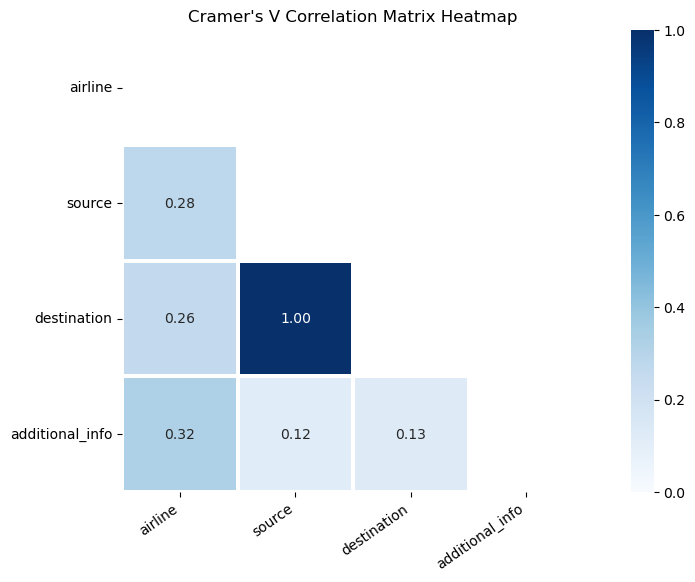

In [21]:
eda_helper_functions.cramersV_heatmap(train)

## 8. Detailed Analysis

In [22]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

In [23]:
train.airline

0       Multiple Carriers
1                Air Asia
2             Jet Airways
3                  Indigo
4             Jet Airways
              ...        
7317            Air India
7318          Jet Airways
7319          Jet Airways
7320               Indigo
7321    Multiple Carriers
Name: airline, Length: 7322, dtype: object

In [24]:
eda_helper_functions.cat_summary(train, "airline")

0       Multiple Carriers
1                Air Asia
2             Jet Airways
3                  Indigo
4             Jet Airways
              ...        
7317            Air India
7318          Jet Airways
7319          Jet Airways
7320               Indigo
7321    Multiple Carriers
Name: airline, Length: 7322, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 7,322 / 7,322 rows


,
count,7322
unique,9
top,Jet Airways
freq,2592


,count,percentage
category,,
Jet Airways,2592,0.354002
Indigo,1445,0.197350
Air India,1160,0.158427
Multiple Carriers,840,0.114723
Spicejet,572,0.078121
Vistara,352,0.048074
Air Asia,215,0.029364
Goair,145,0.019803
Trujet,1,0.000137


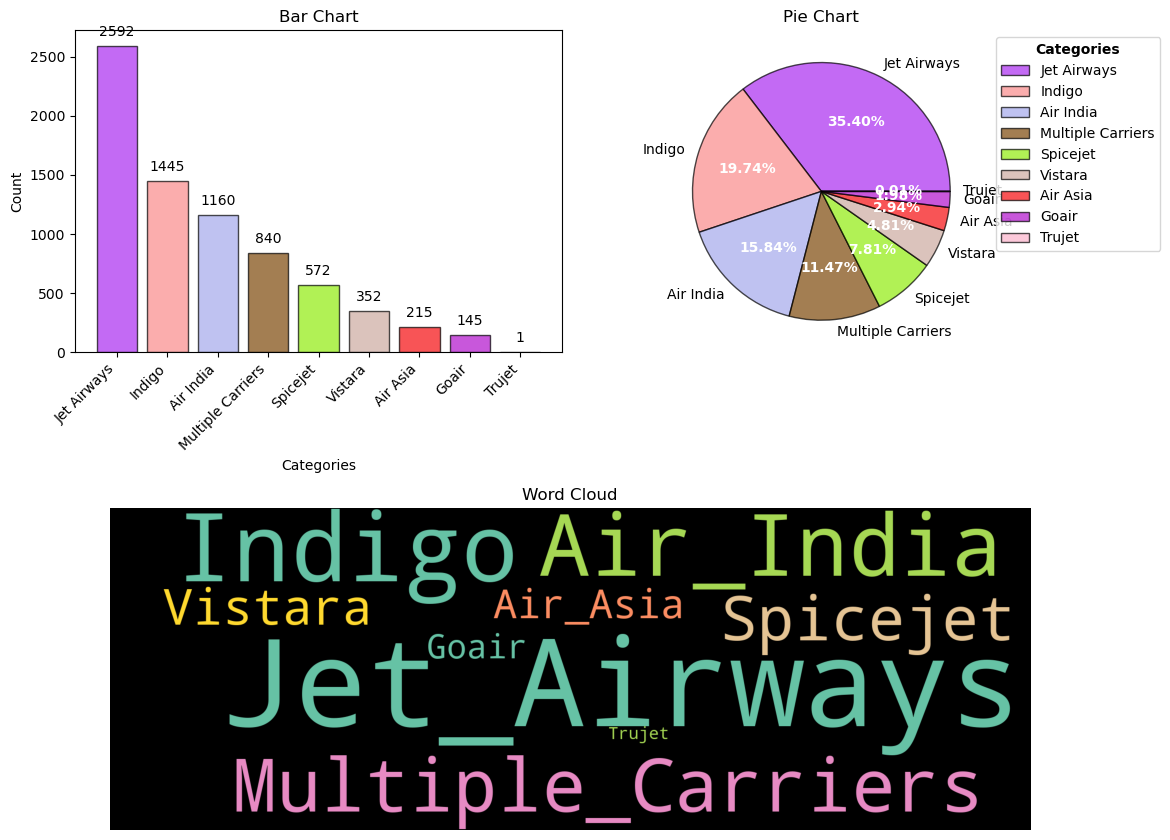

In [25]:
eda_helper_functions.cat_univar_plots(train, "airline")

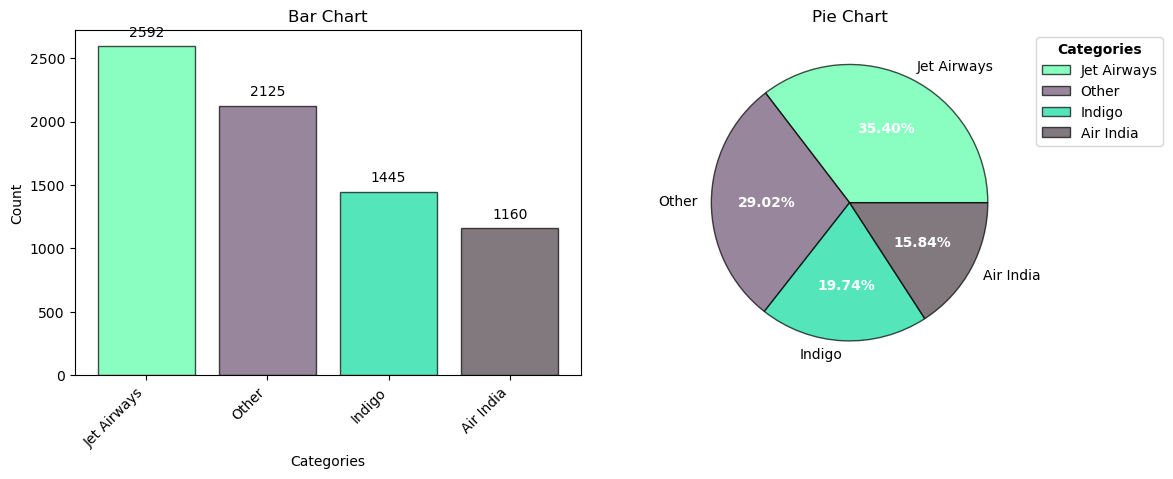

In [26]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=3)

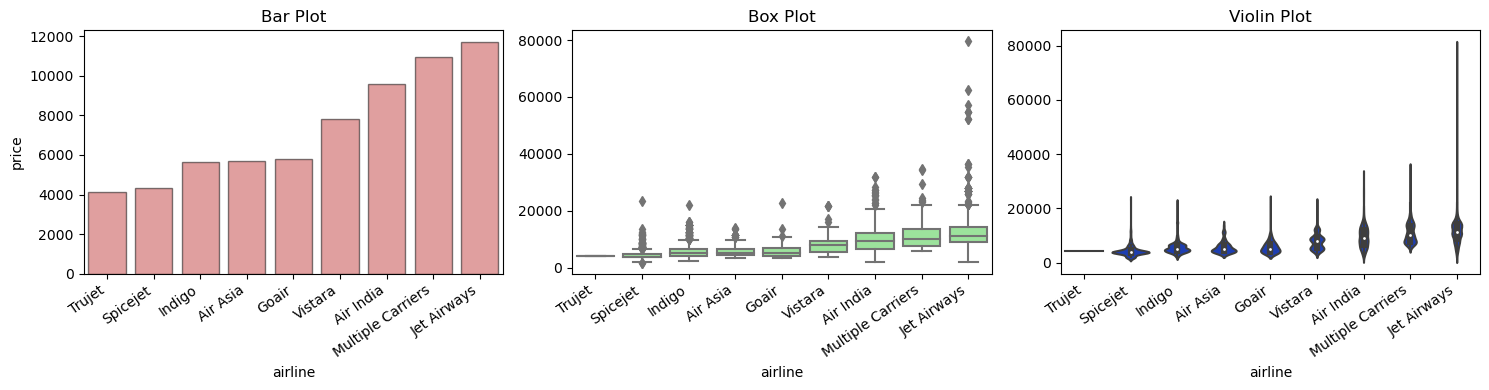

In [27]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="airline"
)

In [28]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 481.10227071552106
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3364.3803422270034
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


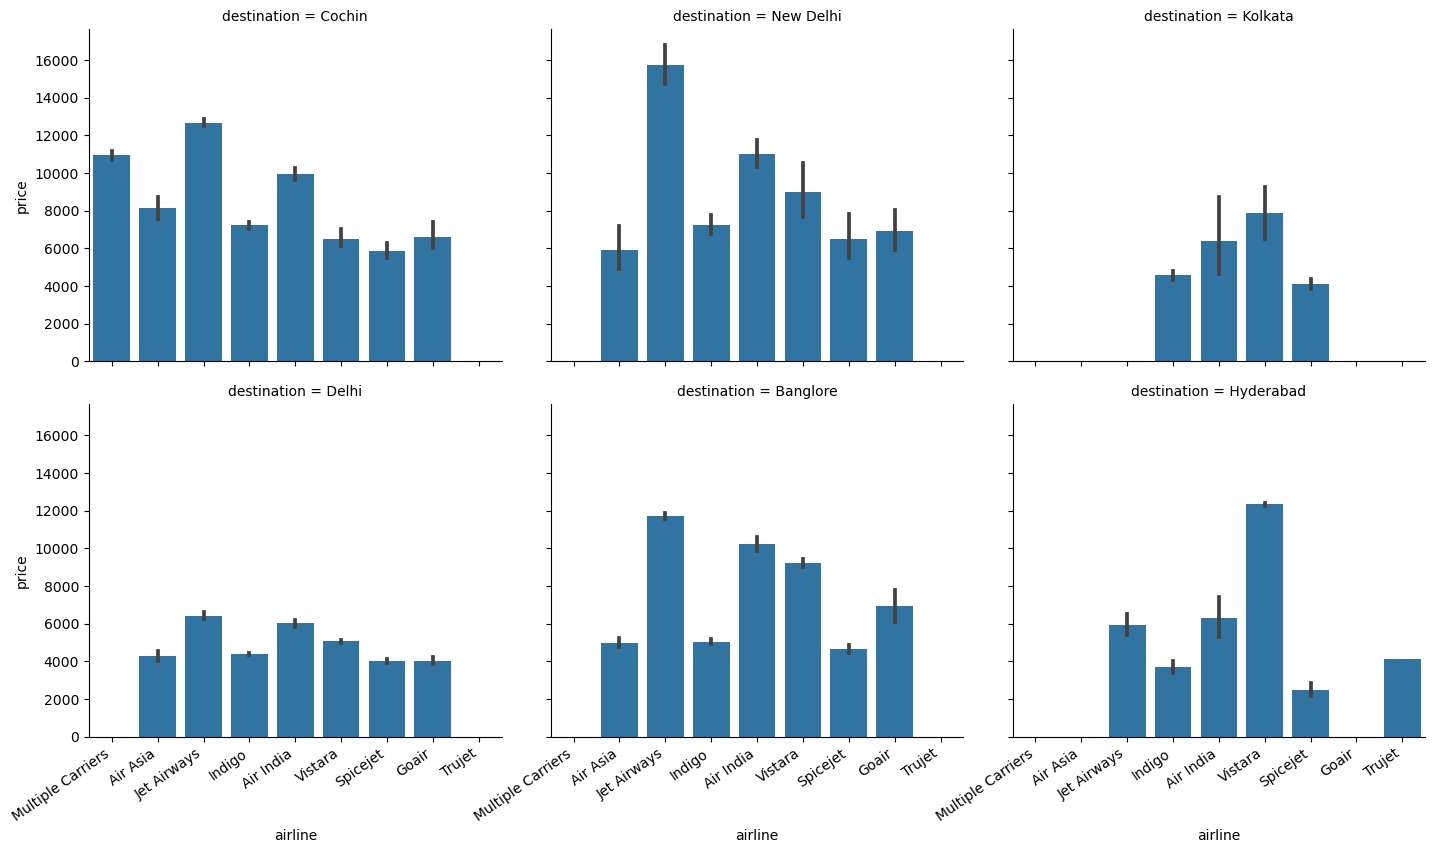

In [29]:
airline_grid = sns.FacetGrid(
	data=train,
	col="destination",
	col_wrap=3,
	height=4,
	aspect=1.2,
	sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
	eda_helper_functions.rotate_xlabels(ax)

### 8.2 date_of_journey

In [30]:
train.date_of_journey

0      2019-03-01
1      2019-03-24
2      2019-05-27
3      2019-03-06
4      2019-05-09
          ...    
7317   2019-03-03
7318   2019-03-27
7319   2019-04-01
7320   2019-06-12
7321   2019-06-24
Name: date_of_journey, Length: 7322, dtype: datetime64[ns]

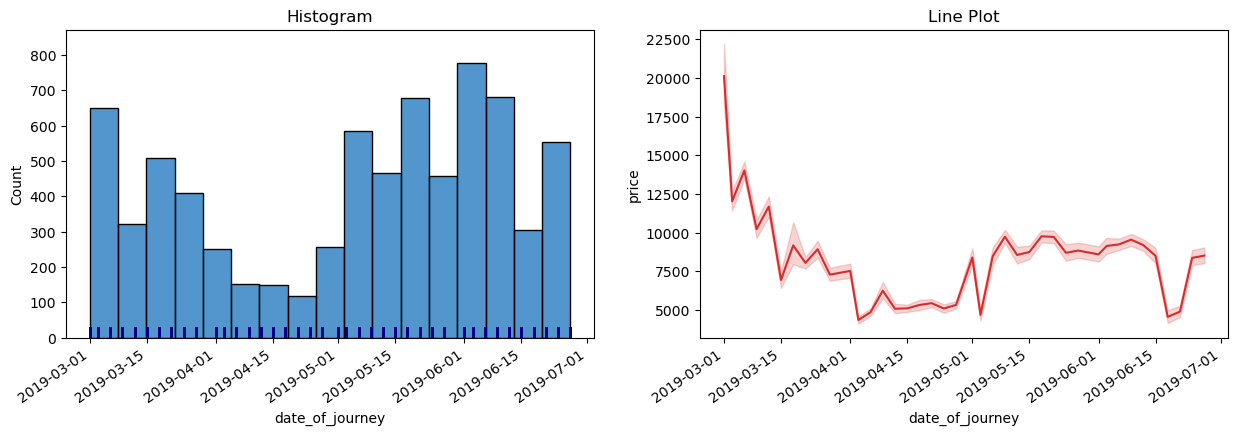

In [31]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_journey",
	target="price"
)

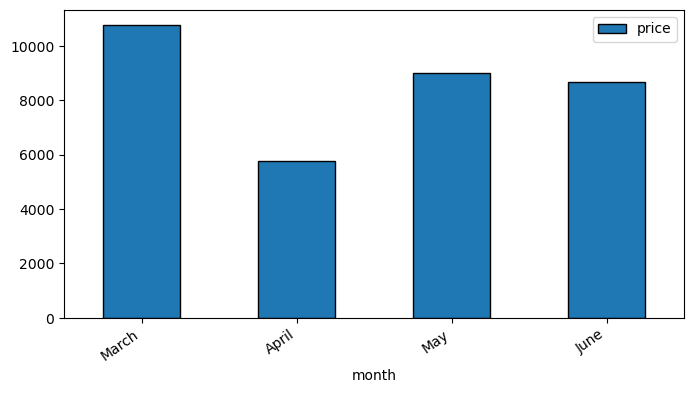

In [32]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

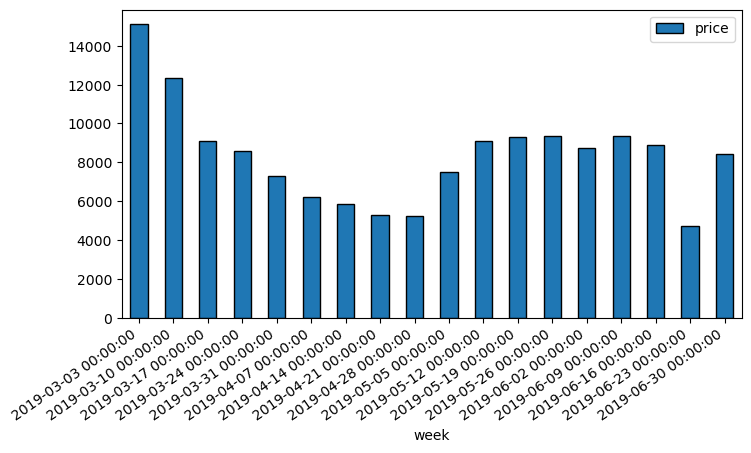

In [33]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

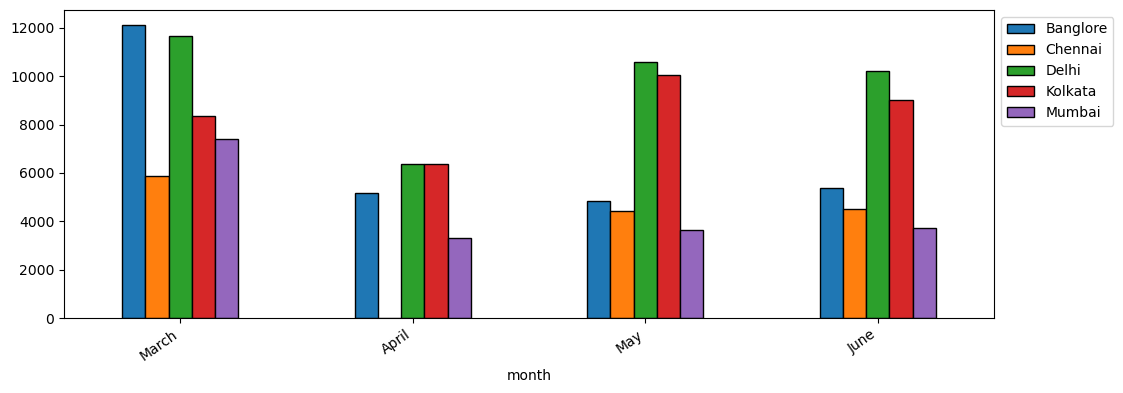

In [34]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

### 8.3 dep_time

In [35]:
train.dep_time

0      2024-05-14 00:20:00
1      2024-05-14 05:50:00
2      2024-05-14 10:00:00
3      2024-05-14 13:20:00
4      2024-05-14 18:55:00
               ...        
7317   2024-05-14 09:45:00
7318   2024-05-14 19:15:00
7319   2024-05-14 21:10:00
7320   2024-05-14 11:25:00
7321   2024-05-14 07:30:00
Name: dep_time, Length: 7322, dtype: datetime64[ns]

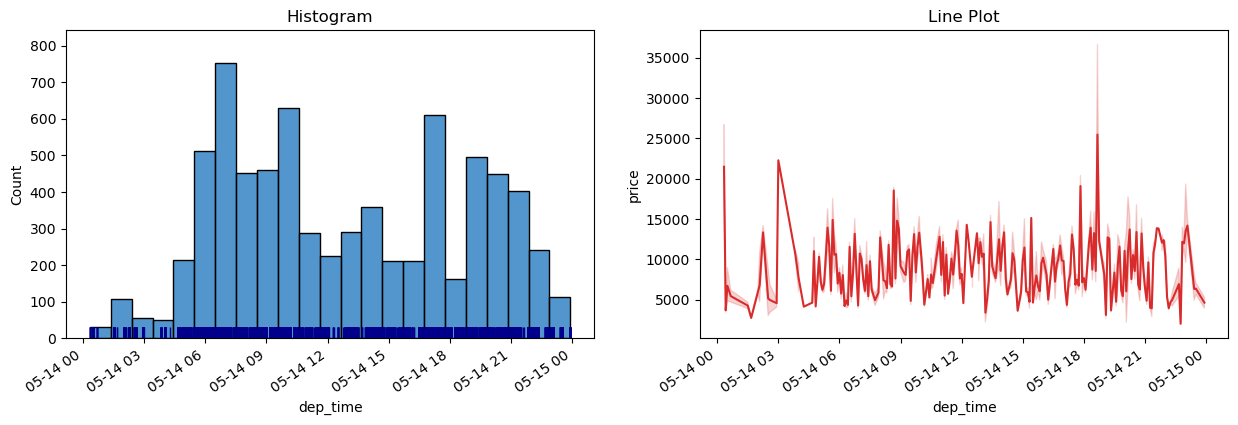

In [36]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

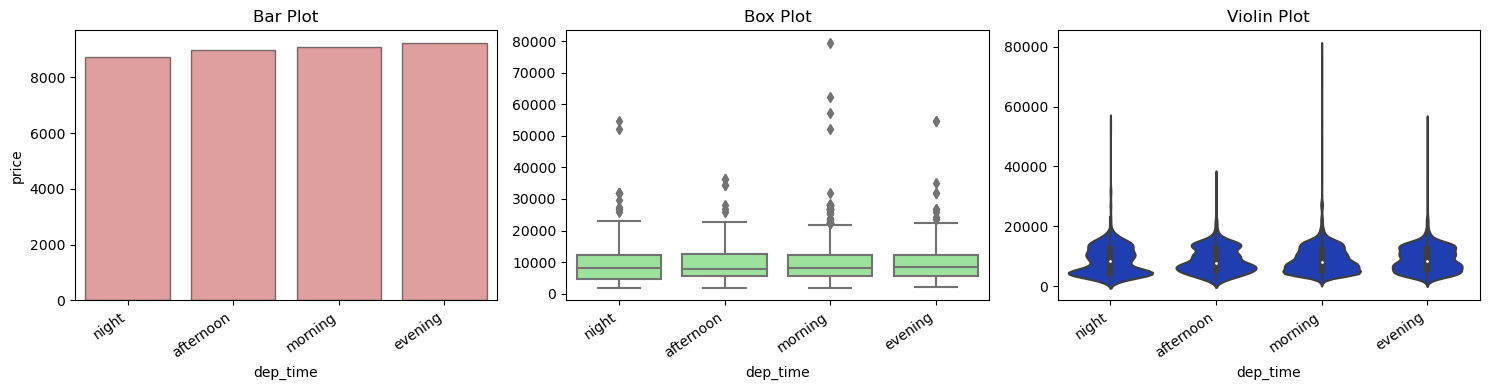

In [37]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

### 8.4 duration

In [38]:
train.duration

0        910
1        170
2       1595
3        135
4        185
        ... 
7317    1420
7318    1470
7319     665
7320     845
7321     690
Name: duration, Length: 7322, dtype: int64

In [39]:
eda_helper_functions.num_summary(train, "duration")

0        910
1        170
2       1595
3        135
4        185
        ... 
7317    1420
7318    1470
7319     665
7320     845
7321     690
Name: duration, Length: 7322, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 7,322 / 7,322 rows


,value
percentile,
0,75.00
5,90.00
10,145.00
25,170.00
50,500.00
75,903.75
90,1435.00
95,1595.00
99,1837.90


,value
mean,625.392652
trimmed mean (5%),591.248103
trimmed mean (10%),562.025435
median,500.000000


,value
var,248715.543795
std,498.713890
IQR,733.750000
mad,330.000000
coef_variance,0.797441


,value
skewness,0.923783
kurtosis,0.015844


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 0.0
Test Statistic       : 0.883640468120575
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 278.92641748402275
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [40]:
train.duration.quantile([0.25, 0.5, 0.75])

0.25    170.00
0.50    500.00
0.75    903.75
Name: duration, dtype: float64

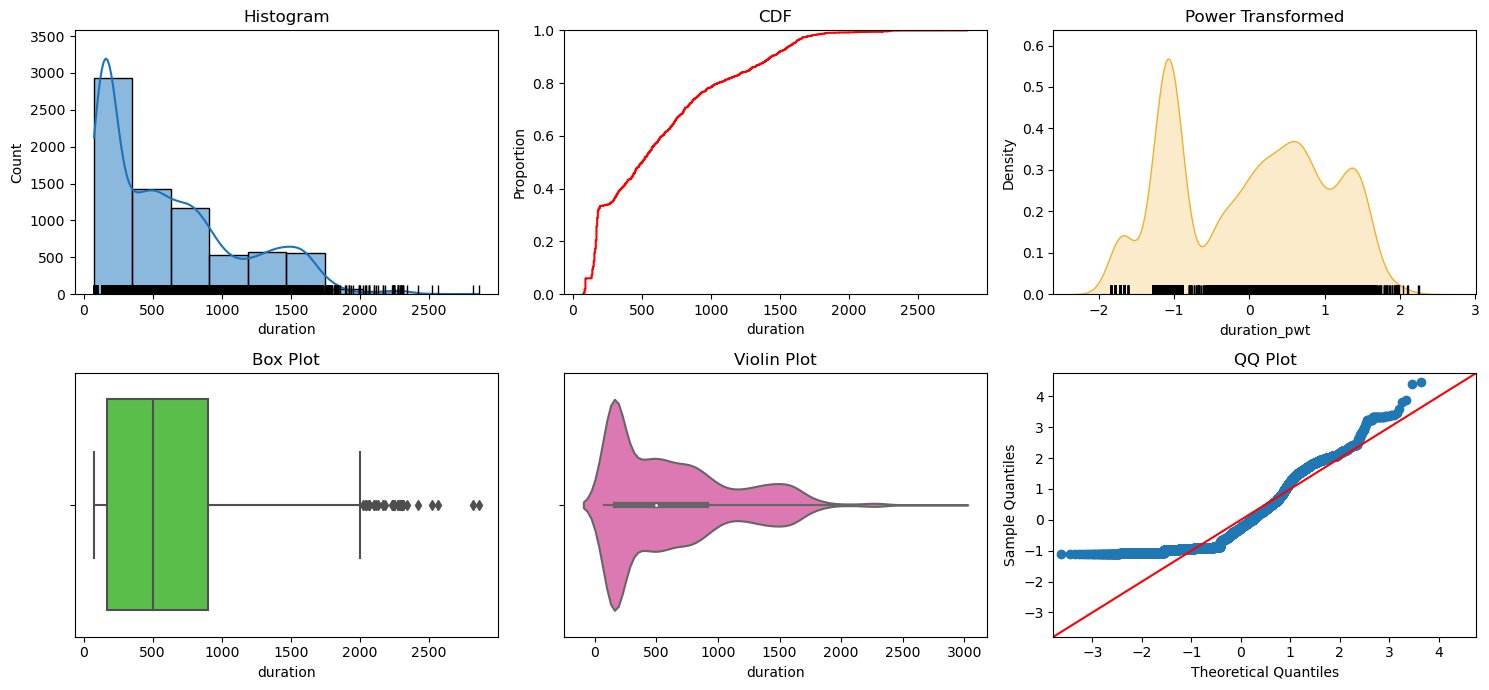

In [41]:
eda_helper_functions.num_univar_plots(train, "duration")

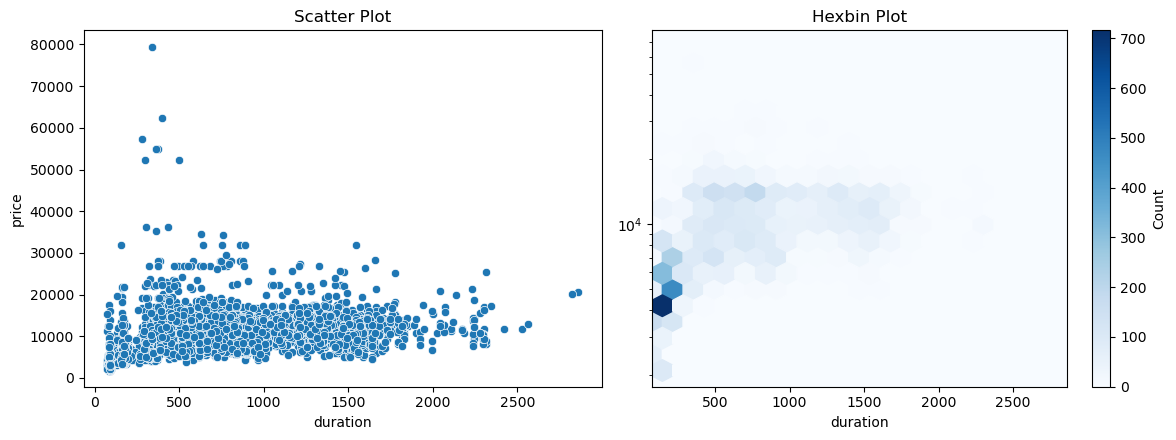

In [42]:
eda_helper_functions.num_bivar_plots(
	train,
	"duration",
	"price",
	hexbin_kwargs=dict(
		yscale="log",
		gridsize=20,
		cmap="Blues"
	)
)

In [43]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.4856084073905449
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.691294835628407
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


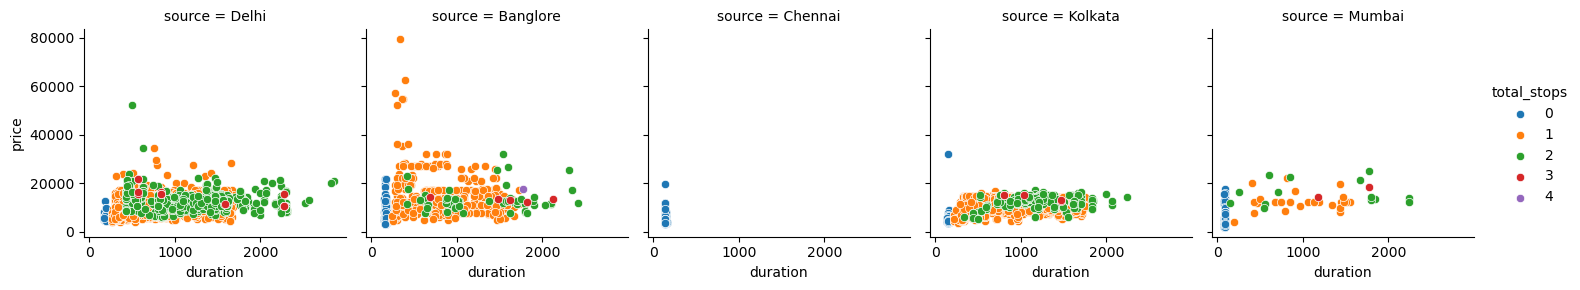

In [44]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

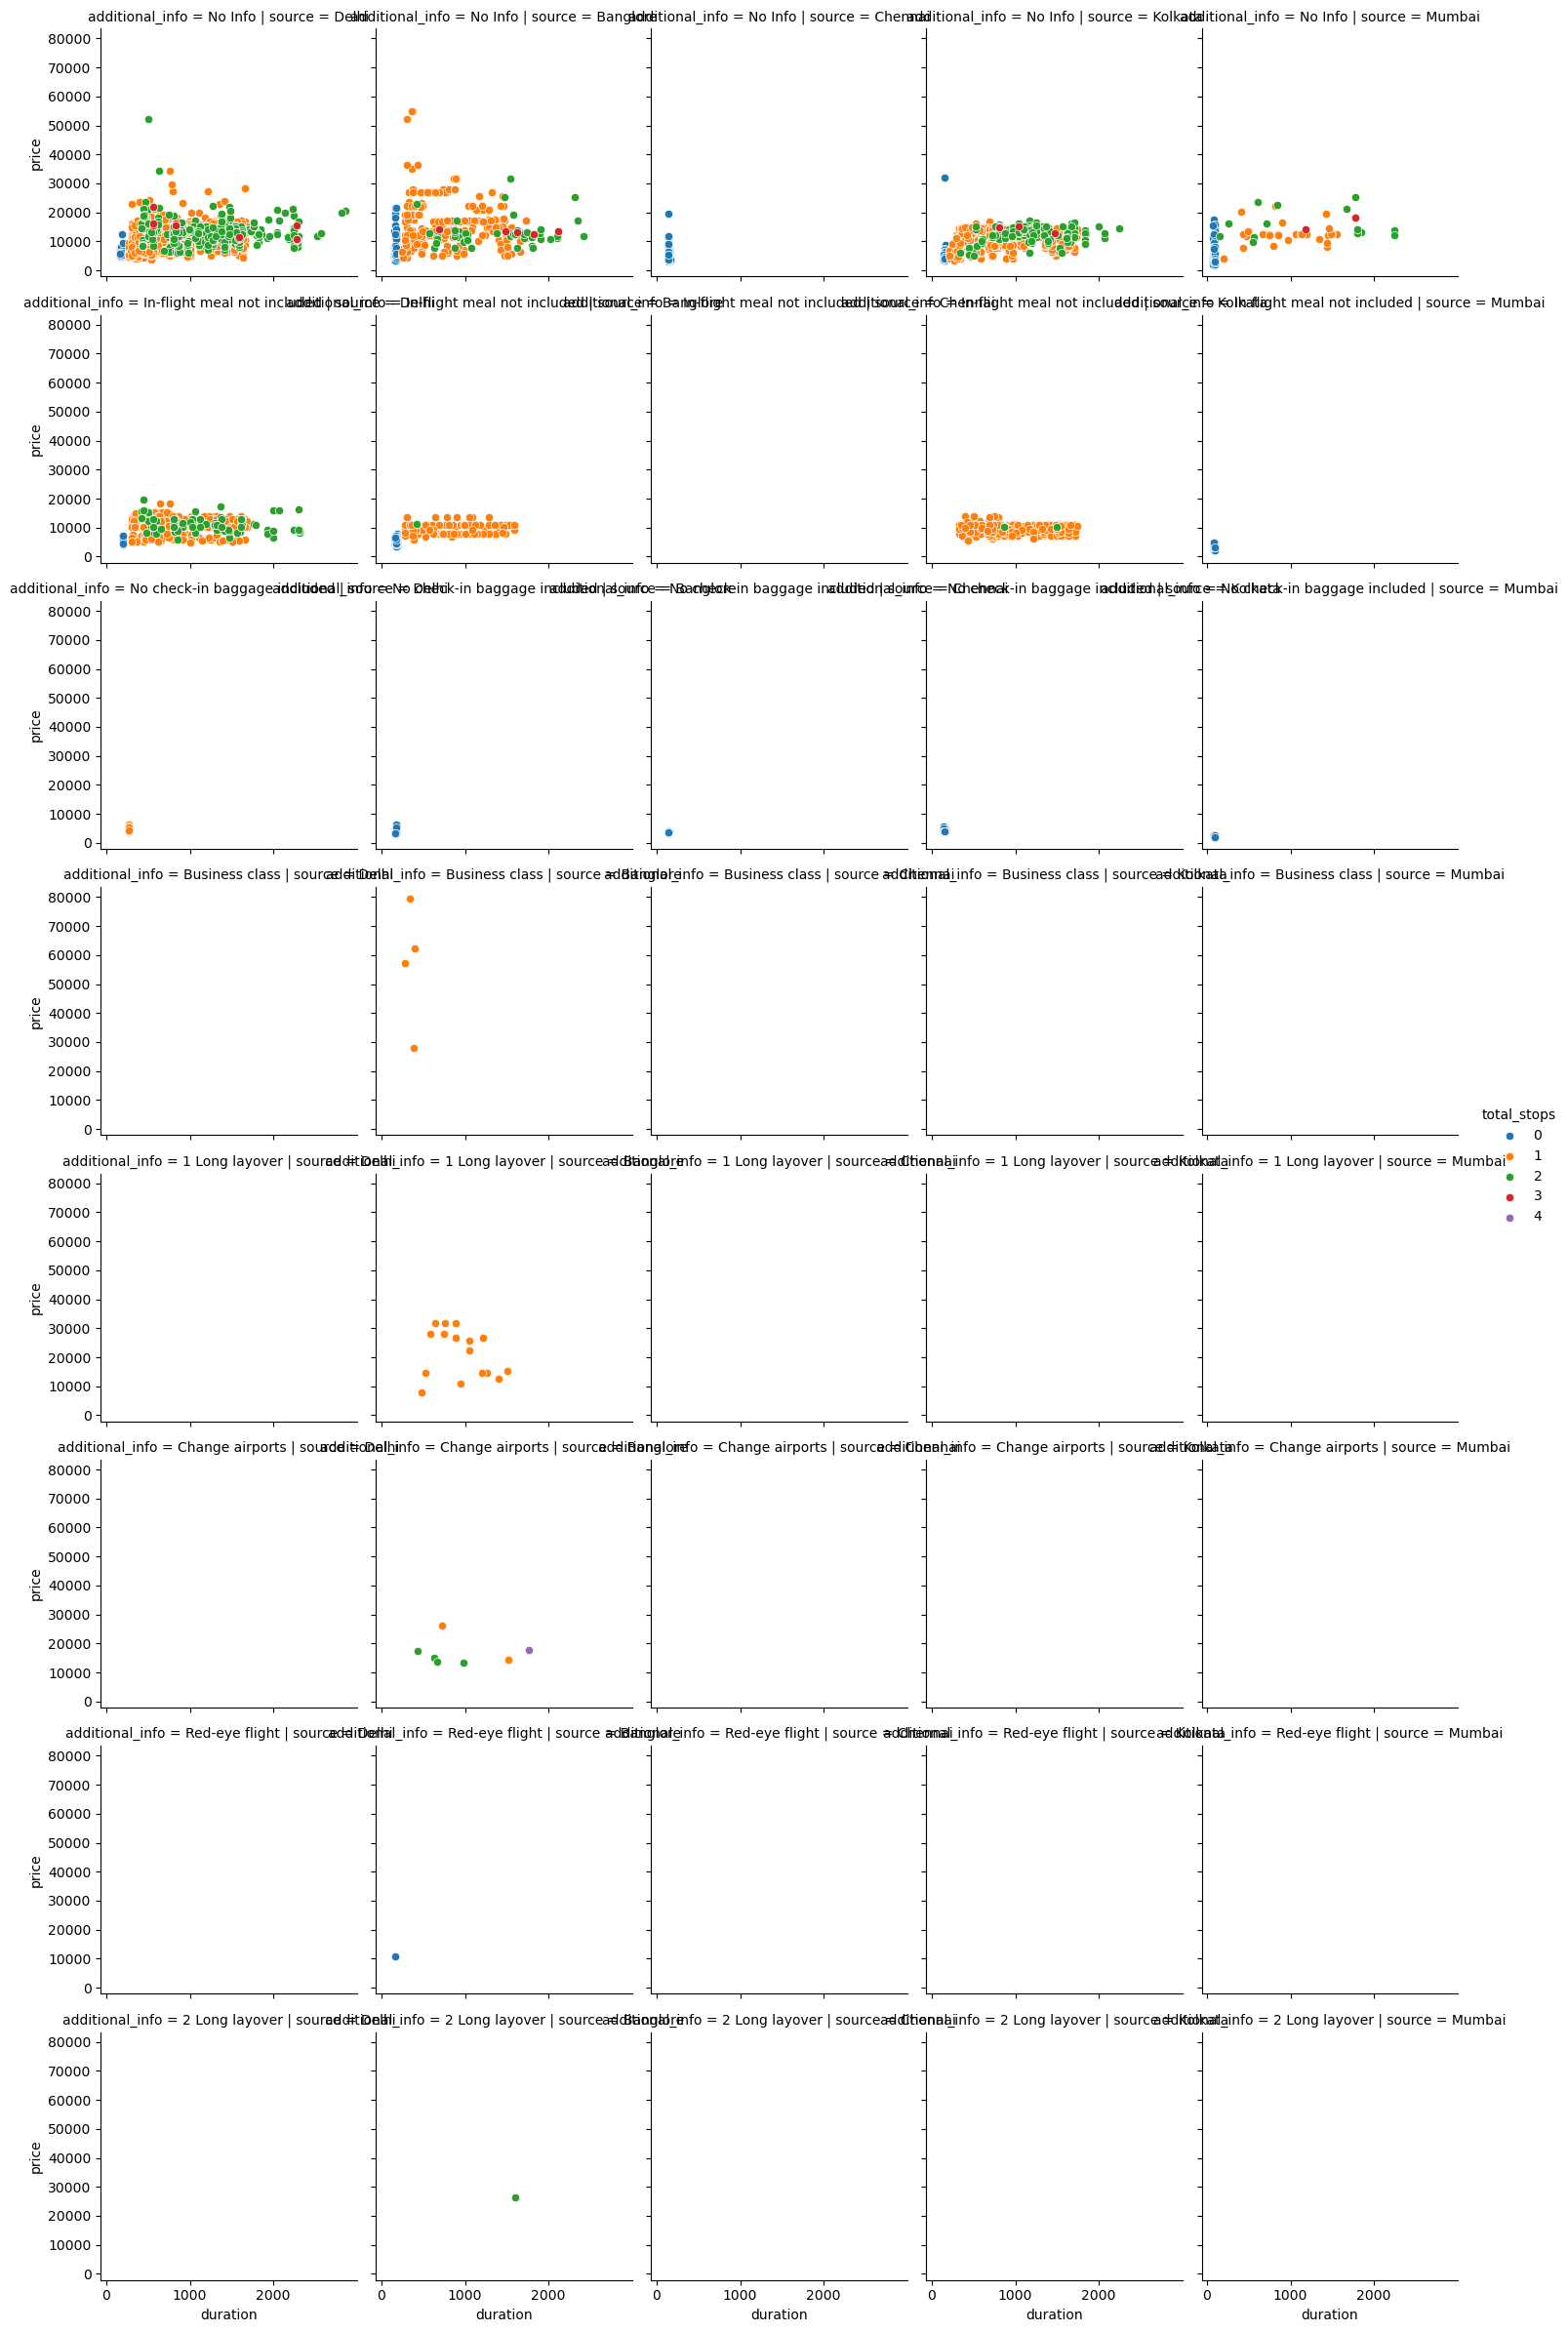

In [45]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [46]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -930.625
Upper Limit : 2004.375


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3491,Air India,2019-03-18,Banglore,New Delhi,2024-05-14 06:45:00,2024-05-14 16:30:00,2025,2,No Info,10835
5031,Jet Airways,2019-03-21,Delhi,Cochin,2024-05-14 18:25:00,2024-05-14 04:25:00,2040,2,No Info,12347
4962,Jet Airways,2019-03-21,Delhi,Cochin,2024-05-14 18:20:00,2024-05-14 04:25:00,2045,2,No Info,13082
5704,Jet Airways,2019-03-03,Delhi,Cochin,2024-05-14 18:20:00,2024-05-14 04:25:00,2045,2,No Info,20747
4001,Air India,2019-05-15,Kolkata,Banglore,2024-05-14 05:50:00,2024-05-14 16:15:00,2065,2,No Info,12723
3532,Air India,2019-05-01,Kolkata,Banglore,2024-05-14 05:50:00,2024-05-14 16:15:00,2065,2,No Info,10991
4980,Jet Airways,2019-03-06,Delhi,Cochin,2024-05-14 17:55:00,2024-05-14 04:25:00,2070,2,In-flight meal not included,15812
207,Jet Airways,2019-03-06,Delhi,Cochin,2024-05-14 17:55:00,2024-05-14 04:25:00,2070,2,No Info,17072
313,Air India,2019-03-18,Banglore,New Delhi,2024-05-14 11:05:00,2024-05-14 22:10:00,2105,2,No Info,11161
1212,Air India,2019-03-03,Banglore,New Delhi,2024-05-14 11:05:00,2024-05-14 22:10:00,2105,2,No Info,11791


### 8.5 additional_info

In [47]:
eda_helper_functions.cat_summary(train, "additional_info")

0                           No Info
1                           No Info
2       In-flight meal not included
3                           No Info
4       In-flight meal not included
                   ...             
7317                        No Info
7318                        No Info
7319    In-flight meal not included
7320                        No Info
7321                        No Info
Name: additional_info, Length: 7322, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 7,322 / 7,322 rows


,
count,7322
unique,8
top,No Info
freq,5715


,count,percentage
category,,
No Info,5715,0.780524
In-flight meal not included,1354,0.184922
No check-in baggage included,224,0.030593
1 Long layover,16,0.002185
Change airports,7,0.000956
Business class,4,0.000546
Red-eye flight,1,0.000137
2 Long layover,1,0.000137


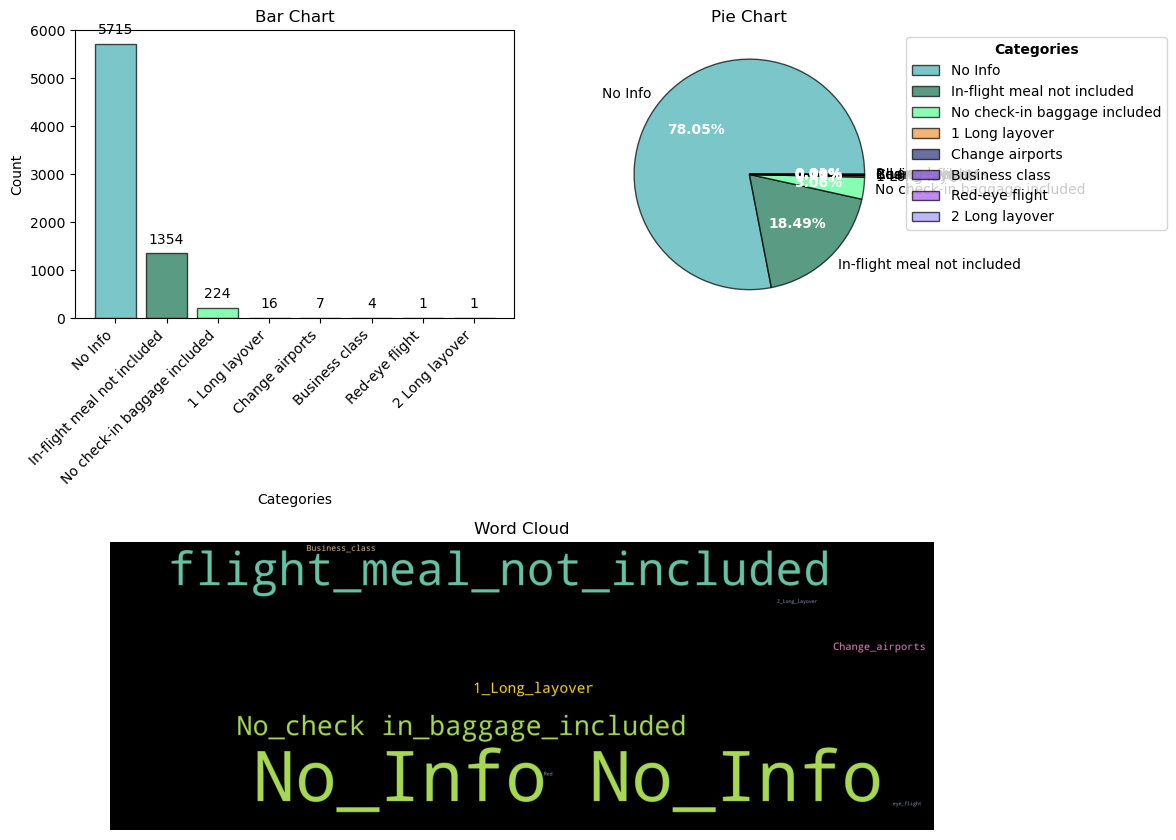

In [48]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

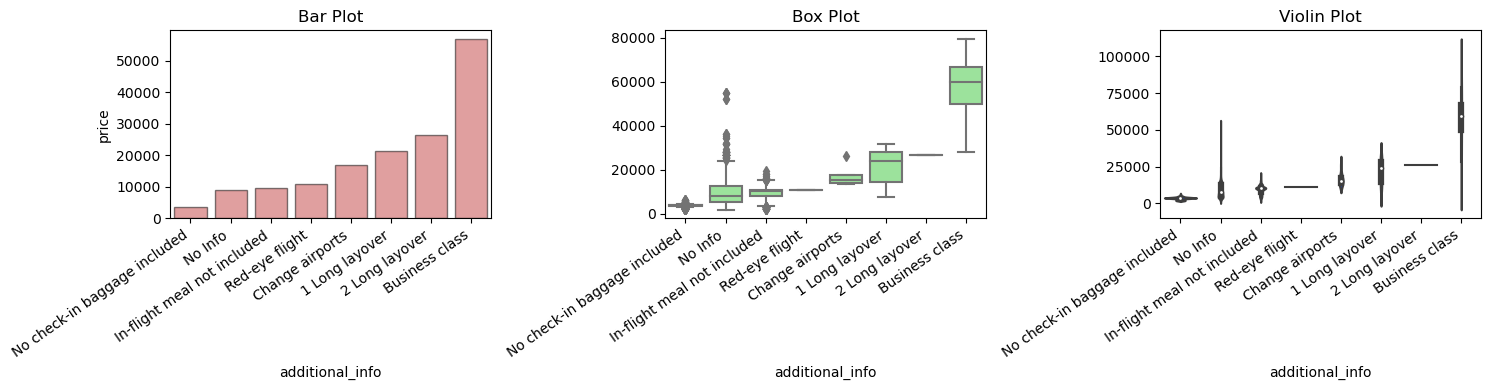

In [49]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")

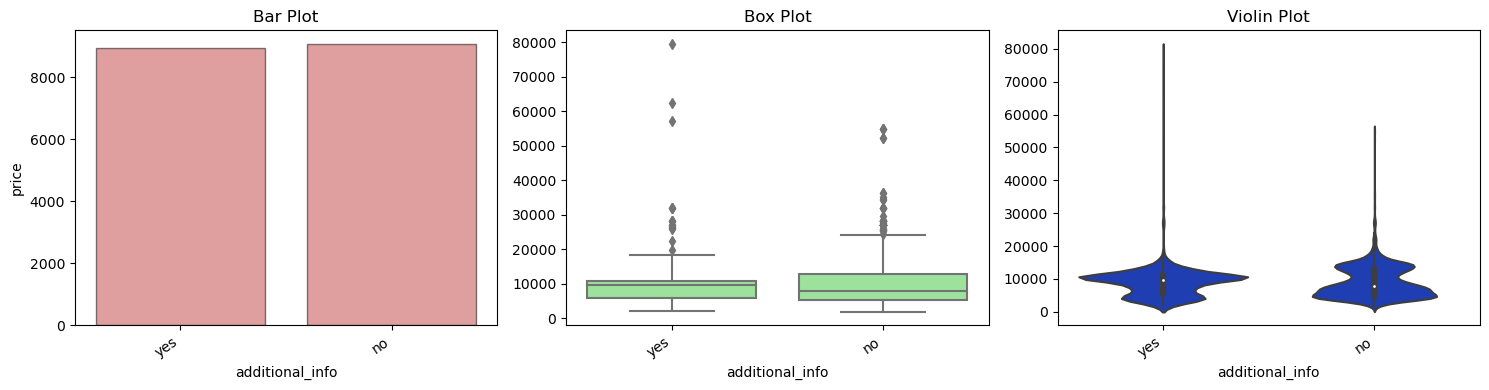

In [50]:
# convertion additional_info into a binary feature for analysis

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

- `additional_info` has severely rare categories
- Converted it into a binary feature for further analysis

## 9. Automated EDA

In [51]:
from ydata_profiling import ProfileReport

In [ ]:
# report = ProfileReport(train)

In [ ]:
# report.to_file(output_file="output.html")